In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.special import expi
from sklearn.metrics import mean_squared_error

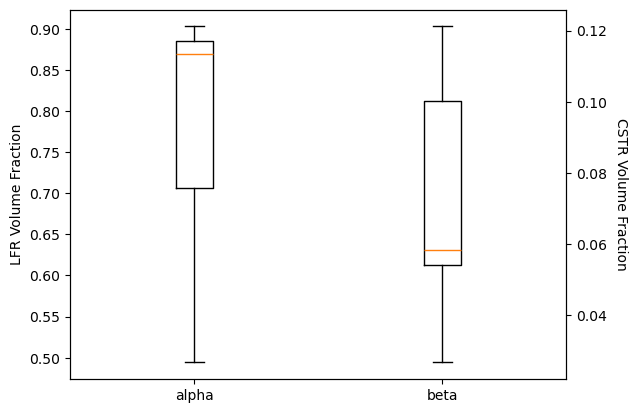

In [14]:
# Visualize distriubtion of LFR_DZ_CSTR parameters
optimal_parameters_df = pd.read_csv(r'C:\Users\jacob\OneDrive - University of Louisville\Projects\Dissertation\PhaseI\data_analysis\TRANSONIC\TRANSONIC\results\run1\results\eval_outputs.csv',
                                    index_col=0, header=0)

fig, ax = plt.subplots()
ax.boxplot(optimal_parameters_df['alpha'], labels=['alpha'])
ax2 = ax.twinx()
ax2.boxplot(optimal_parameters_df['beta'], positions=[2], labels=['beta'])
ax.set_ylabel('LFR Volume Fraction')
ax2.set_ylabel('CSTR Volume Fraction', rotation=-90, labelpad=15)
plt.show()

In [15]:
# Generate Random Pairs of alpha and beta
alphas = np.random.uniform(0.01, 0.99, 250)
betas = np.random.uniform(0.1, 0.99, 250)

pairs = list(zip(alphas, betas))
pairs = [(a, b) for a, b in pairs if a+b<=1]
pairs

[(0.0191658037289655, 0.9475349691779039),
 (0.2880190372870797, 0.4444161637902049),
 (0.614325622827222, 0.35119610129644774),
 (0.09155130781240423, 0.7951271542043303),
 (0.2736463279292223, 0.24297573714340312),
 (0.043288695101783854, 0.5548022109296514),
 (0.28555291693488893, 0.5570541607295839),
 (0.05434139709123555, 0.9301441868421976),
 (0.10647303061417467, 0.5140577819345479),
 (0.24524696873087048, 0.26903242602405636),
 (0.3881538384549119, 0.3668436470051537),
 (0.21082828382421087, 0.6607874120854649),
 (0.06588387743676573, 0.43217642542498513),
 (0.034708634047668926, 0.22959612380587147),
 (0.31375964971557857, 0.5634506051148404),
 (0.22044425260739653, 0.5448655850693993),
 (0.1362648904040689, 0.573200182108059),
 (0.0342153986504763, 0.9290863322196691),
 (0.300364305445736, 0.6645994067526202),
 (0.38686343780566784, 0.15350570930437674),
 (0.5381349243397217, 0.37850628985557166),
 (0.44477113851287625, 0.5221304606188214),
 (0.08810434627898996, 0.3935817599

In [16]:

import numpy as np 
from scipy.optimize import curve_fit, differential_evolution

class Model:
    def __init__(self, initial_guess=None):
        self.initial_guess = initial_guess


    def fit(self, xdata, ytrue, polish_bool=True):
        '''
        A two-step optimization procedure where differential evolution is 
        applied first and then a polishing step with a gradient based method 
        is used. Fits the model instance to the provided ground truth data.

        Parameters:
        - xdata : np.array
            time sequence to fit over
        - ytrue : np.array
            the ground truth data to fit the model to 
        - polish_bool : bool 
            Bool for whether or not to perform the gradient based optimization step

        Returns: 
        - Nothing, but sets model attribute "params" to optimally found parameters
        '''

        result = differential_evolution(self.objective, 
                                        self.bounds, 
                                        args=(xdata, ytrue),
                                        polish=polish_bool,
                                        seed=69)
        self.params = result.x


    def scipy_curve_fit(self, xdata, ydata, bounds=None):
        try: 
            popt, pcov = curve_fit(self.function, xdata, ydata, 
                                bounds=bounds , p0=self.initial_guess)
            self.params = popt
        except RuntimeError as e:
            print(f"{e}: Couldn't find optimal parameters")
            self.params = [0, 0, 0]
    
    def predict(self, xdata):
        return self.function(xdata, *self.params)
    
    def function(self, x, *params):
        raise NotImplementedError("This method should be implemented by subclasses.")
    
    def objective(self, params, args):
         raise NotImplementedError("This method should be implemented by subclasses.")


In [17]:
from scipy.special import expi
import numpy as np
from sklearn.metrics import mean_squared_error


class LFR_DZ_CSTR(Model):
    """
    LFR_DZ_CSTR model represents a system where all flow first enters a 
    laminar flow reactor (LFR).The outlet of the LFR goes directly to the 
    CSTR. The model has two primary parameters:
    - a : the fraction of real volume that is described by the LFR
    - b : the fraction of real volume that is described by the CSTR

    Attributes:
    - dt : the amount of time during which the tracer was injected (CFD sim dt)
    - tau : the spacetime of the reactor defined by volume / flow rate
    - bounds : the bounds for the model parameters which are optimized for
    - C0 : initial concnetration injected in pulse experiment

    Notes: 
    - This is currently the best model for Phase I of Miller's dissertation
    - A third parameter that is not a degree of freedom, call it c, is found by
      subtracting the sum of a and b from 1. This is representative of the 
      fraction of the volume represented as a stagnant or deadzone. 
    """

    def __init__(self, dt, tau, bounds=None, initial_guess=None, C0=1):
        """
        Initializes the model 

        Parameters: 
        - See class level doc string
        """

        super().__init__(initial_guess=initial_guess)
        self.dt = dt
        self.tau = tau
        self.bounds = bounds
        self.C0 = C0
    

    def exp_term(self, t, m):
        """
        This is a necessary term for calculating the outlet of the CSTR
        """

        return np.exp(m*t)*(m*t + 1)/t**2

    def expi_term(self, t, m):
        """
        This is a necessary term for calculating the outlet of the CSTR
        """

        return m**2 * expi(m*t)

    def outlet_concentration(self, t, a, b):
        """
        Calculates the concentration leaving the CSTR for some time, t

        Parameters:
        - a : the fraction of volume given by the LFR
        - b : the fraction of volume given by the CSTR

        Returns:
        - The concentration leaving the CSTR at time t

        """

        tau_LFR = a*self.tau
        tau_CSTR = b*self.tau

        m = 1 / tau_CSTR
        n = tau_LFR**2 * self.C0 * self.dt / 2 / tau_CSTR
        C_0 = 0
        C_IC = n*0.5*(self.exp_term(tau_LFR/2, m) - self.expi_term(tau_LFR/2, m))
        C_1 = (C_IC - 0.5*n*(self.exp_term(t, m) - self.expi_term(t, m)))/np.exp(m*t)
        C_CSTR_out = np.where(t < tau_LFR/2, C_0, C_1)
        return C_CSTR_out
    
    def function(self, xdata, a, b):
        return self.outlet_concentration(xdata, a, b)

    def objective(self, params, xdata, ytrue):
        '''
        This was the first deployment of the objective function method in a 
        model class. 

        Parameters: 
        - params : a tuple containing the model parameters a and b
        - xdata : the time series to predict over
        - ytrue : the CFD RTD data

        Returns:
        - np.float : the mean squared error term plus a penalty constraint
        '''

        a, b = params
        penalty = 0

        # Penalty term to ensure that sum of a and b is never greater than 1 
        if a + b > 1:
            penalty = 1000 * (a + b - 1)**2
        y_predicted = self.function(xdata, a, b)
        return mean_squared_error(ytrue, y_predicted) + penalty

C:\Users\jacob\AppData\Local\Temp\ipykernel_6620\2249592324.py:47: RuntimeWarning: divide by zero encountered in divide
  return np.exp(m*t)*(m*t + 1)/t**2
C:\Users\jacob\AppData\Local\Temp\ipykernel_6620\2249592324.py:47: RuntimeWarning: divide by zero encountered in divide
  return np.exp(m*t)*(m*t + 1)/t**2
C:\Users\jacob\AppData\Local\Temp\ipykernel_6620\2249592324.py:47: RuntimeWarning: divide by zero encountered in divide
  return np.exp(m*t)*(m*t + 1)/t**2
C:\Users\jacob\AppData\Local\Temp\ipykernel_6620\2249592324.py:47: RuntimeWarning: divide by zero encountered in divide
  return np.exp(m*t)*(m*t + 1)/t**2
C:\Users\jacob\AppData\Local\Temp\ipykernel_6620\2249592324.py:47: RuntimeWarning: divide by zero encountered in divide
  return np.exp(m*t)*(m*t + 1)/t**2
C:\Users\jacob\AppData\Local\Temp\ipykernel_6620\2249592324.py:47: RuntimeWarning: divide by zero encountered in divide
  return np.exp(m*t)*(m*t + 1)/t**2
C:\Users\jacob\AppData\Local\Temp\ipykernel_6620\2249592324.py:4

[0.28555292 0.55705416] (0.28555291693488893, 0.5570541607295839)


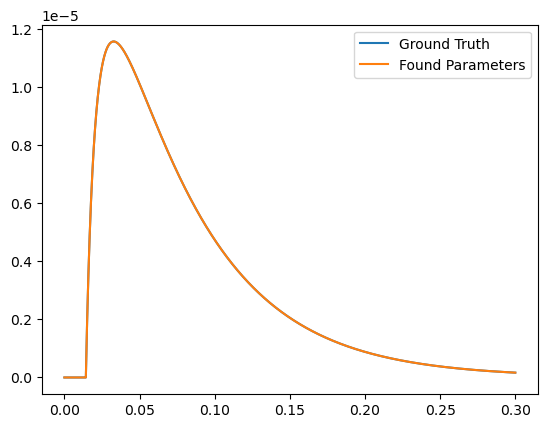

In [25]:
# Testing 
mean_RT = 0.1
model = LFR_DZ_CSTR(1e-6, mean_RT, bounds=[(0.01, 0.99), (0.01, 0.99)])


t = np.linspace(0, 3*mean_RT, 5000)
Ct = model.function(t, *pairs[6])
model.fit(t.reshape(-1, 1), Ct.reshape(-1, 1))
print(model.params, pairs[6])

plt.figure()
plt.plot(t, Ct, label='Ground Truth')
plt.plot(t, model.function(t, *model.params), label='Found Parameters')
plt.legend()
plt.show()